In [1]:
# Kaggle notebook cell

import os, json, random, math
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, confusion_matrix, classification_report

# ---------------------------
# PATHS (YOUR DATA)
# ---------------------------
JSON_PATH    = "/kaggle/input/fundus-images/data_info.json"
ROOT_IMG_DIR = "/kaggle/input/fundus-images/Fundus_CIMT_2903"  # folder that contains the images (recursively)

# ---------------------------
# CONFIG
# ---------------------------
IMG_SIZE   = 384
BATCH_SIZE = 16
EPOCHS     = 20
LR         = 3e-4
WD         = 1e-4
MODEL_NAME = "resnet50"   # change to resnet34 on CPU
SEED       = 42
DEVICE     = "cuda" if torch.cuda.is_available() else "cpu"

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

# ---------------------------
# LOAD JSON
# Expected keys per record:
#   label (0/1), and image names under keys like left_eye/right_eye (robustly handled below)
# ---------------------------
with open(JSON_PATH, "r") as f:
    meta = json.load(f)

# ---------------------------
# INDEX ALL IMAGES RECURSIVELY, ANY EXTENSION
# ---------------------------
root = Path(ROOT_IMG_DIR)
assert root.exists(), f"Image root not found: {root.resolve()}"

img_paths = [p for p in root.rglob("*") if p.suffix.lower() in {".png", ".jpg", ".jpeg"}]
assert len(img_paths) > 0, f"No image files found under {root.resolve()}"

# maps: basename and stem (case-insensitive)
by_basename = {p.name.lower(): p for p in img_paths}
by_stem = {}
for p in img_paths:
    by_stem.setdefault(p.stem.lower(), p)

def resolve_image(name_from_json: str):
    if not name_from_json:
        return None
    n = name_from_json.strip().lower()
    # exact basename
    if n in by_basename:
        return by_basename[n]
    # try extension swaps
    stem = Path(n).stem
    for ext in (".png", ".jpg", ".jpeg"):
        cand = stem + ext
        if cand in by_basename:
            return by_basename[cand]
    # try stem-only
    return by_stem.get(stem, None)

# robust key options for left/right
EYE_KEYS = [
    "left_eye","right_eye",
    "left","right",
    "left_img","right_img",
    "left_eye_name","right_eye_name"
]

def get_eye_names(entry: dict):
    names = []
    for k in EYE_KEYS:
        if k in entry and entry[k]:
            names.append(entry[k])
    return names

def parse_label(x):
    try:
        return int(x)
    except:
        # handle labels like "risk"/"no-risk"
        s = str(x).strip().lower()
        if s in {"1","true","risk","positive","yes"}:
            return 1
        return 0

# ---------------------------
# BUILD DATAFRAME FROM JSON USING RESOLVER
# ---------------------------
rows, missing = [], []
for pid, info in meta.items():
    label = parse_label(info.get("label", 0))
    eye_names = get_eye_names(info)
    if not eye_names:
        # sometimes dataset stores a single 'image' key
        single = info.get("image") or info.get("img") or info.get("filename")
        if single:
            eye_names = [single]
    for fname in eye_names:
        path = resolve_image(fname)
        if path is None:
            missing.append((pid, fname))
            continue
        rows.append({"pid": pid, "img_path": str(path), "label": label})

df = pd.DataFrame(rows)
print(f"Resolved {len(df)} images.")
if missing:
    print(f"Unresolved: {len(missing)} (showing up to 10)")
    for m in missing[:10]:
        print("  PID:", m[0], "Name:", m[1])

assert len(df) > 0, "No images resolved. Check folder and JSON filename formatting."

# ---------------------------
# SPLIT (stratified)
# ---------------------------
train_df, tmp_df = train_test_split(df, test_size=0.3, random_state=SEED, stratify=df["label"])
val_df, test_df  = train_test_split(tmp_df, test_size=0.5, random_state=SEED, stratify=tmp_df["label"])

print(f"Train:{len(train_df)}  Val:{len(val_df)}  Test:{len(test_df)}")
print("Train class balance:\n", train_df['label'].value_counts())

# ---------------------------
# TRANSFORMS
# ---------------------------
train_tfms = transforms.Compose([
    transforms.Resize(int(IMG_SIZE*1.1)),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.85, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

val_tfms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

# ---------------------------
# DATASET/LOADERS
# ---------------------------
class FundusDataset(Dataset):
    def __init__(self, df, tfm):
        self.df = df.reset_index(drop=True)
        self.tfm = tfm
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        row = self.df.iloc[i]
        img = Image.open(row.img_path).convert("RGB")
        img = self.tfm(img)
        label = torch.tensor(row.label, dtype=torch.float32)
        return img, label

train_ds = FundusDataset(train_df, train_tfms)
val_ds   = FundusDataset(val_df,   val_tfms)
test_ds  = FundusDataset(test_df,  val_tfms)

# Weighted sampler (helps if classes are imbalanced)
class_counts = train_df['label'].value_counts().to_dict()
class_weights = {c: len(train_df)/class_counts[c] for c in class_counts}
sample_weights = [class_weights[y] for y in train_df['label']]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

num_workers = 2 if DEVICE == "cuda" else 0
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=num_workers, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)

# ---------------------------
# MODEL
# ---------------------------
def build_resnet(name="resnet50"):
    if name == "resnet18":
        m = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        in_f = m.fc.in_features
    elif name == "resnet34":
        m = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
        in_f = m.fc.in_features
    elif name == "resnet50":
        m = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        in_f = m.fc.in_features
    else:
        raise ValueError("Pick resnet18/34/50")
    m.fc = nn.Linear(in_f, 1)  # binary logit
    return m

model = build_resnet(MODEL_NAME).to(DEVICE)

# (Optional) freeze backbone for a warm-up phase
for n, p in list(model.named_parameters())[:-2]:
    p.requires_grad = False

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LR, weight_decay=WD)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

# ---------------------------
# TRAIN / EVAL
# ---------------------------
def run_epoch(loader, train=True):
    model.train(train)
    total_loss, logits_all, labels_all = 0.0, [], []
    for imgs, labels in loader:
        imgs = imgs.to(DEVICE, non_blocking=True)
        labels = labels.to(DEVICE).unsqueeze(1)
        with torch.set_grad_enabled(train):
            logits = model(imgs)
            loss = criterion(logits, labels)
            if train:
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
                optimizer.step()
        total_loss += loss.item() * imgs.size(0)
        logits_all.append(logits.detach().cpu().numpy())
        labels_all.append(labels.detach().cpu().numpy())
    logits_all = np.concatenate(logits_all, axis=0).ravel()
    labels_all = np.concatenate(labels_all, axis=0).ravel()
    probs = 1/(1+np.exp(-logits_all))
    preds = (probs >= 0.5).astype(int)
    acc = accuracy_score(labels_all, preds)
    f1  = f1_score(labels_all, preds)
    try:
        auc = roc_auc_score(labels_all, probs)
    except ValueError:
        auc = float("nan")
    loss_avg = total_loss / len(loader.dataset)
    return loss_avg, acc, f1, auc, preds, probs, labels_all

best = -1; patience = 5; bad = 0
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc, tr_f1, tr_auc, *_ = run_epoch(train_loader, train=True)
    va_loss, va_acc, va_f1, va_auc, *_ = run_epoch(val_loader,   train=False)
    scheduler.step()
    print(f"Epoch {epoch:02d} | "
          f"train: loss {tr_loss:.4f} acc {tr_acc:.3f} f1 {tr_f1:.3f} auc {tr_auc:.3f} || "
          f"val: loss {va_loss:.4f} acc {va_acc:.3f} f1 {va_f1:.3f} auc {va_auc:.3f}")
    score = va_auc if not math.isnan(va_auc) else va_acc
    if score > best:
        best = score; bad = 0
        torch.save(model.state_dict(), "best_resnet_cvd.pt")
    else:
        bad += 1
        if bad >= patience:
            print("Early stopping.")
            break

# Unfreeze & fine-tune (optional small LR)
for p in model.parameters():
    p.requires_grad = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=WD)
for epoch in range(3):  # brief fine-tune
    tr_loss, tr_acc, tr_f1, tr_auc, *_ = run_epoch(train_loader, train=True)
    va_loss, va_acc, va_f1, va_auc, *_ = run_epoch(val_loader,   train=False)
    print(f"FT Epoch {epoch+1} | "
          f"train loss {tr_loss:.4f} acc {tr_acc:.3f} f1 {tr_f1:.3f} auc {tr_auc:.3f} || "
          f"val loss {va_loss:.4f} acc {va_acc:.3f} f1 {va_f1:.3f} auc {va_auc:.3f}")
    torch.save(model.state_dict(), "best_resnet_cvd.pt")

# ---------------------------
# TEST
# ---------------------------
model.load_state_dict(torch.load("best_resnet_cvd.pt", map_location=DEVICE))
test_loss, test_acc, test_f1, test_auc, preds, probs, labels = run_epoch(test_loader, train=False)
print("\nTEST RESULTS")
print(f"Loss: {test_loss:.4f}  Acc: {test_acc:.3f}  F1: {test_f1:.3f}  AUROC: {test_auc:.3f}")
print("Confusion Matrix:\n", confusion_matrix(labels, preds))
print("\nClassification Report:\n", classification_report(labels, preds, digits=3))


Resolved 5806 images.
Train:4064  Val:871  Test:871
Train class balance:
 label
1    2875
0    1189
Name: count, dtype: int64


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 188MB/s] 


Epoch 01 | train: loss 0.6421 acc 0.663 f1 0.703 auc 0.735 || val: loss 0.6018 acc 0.739 f1 0.806 auc 0.785
Epoch 02 | train: loss 0.6004 acc 0.702 f1 0.697 auc 0.760 || val: loss 0.5953 acc 0.729 f1 0.790 auc 0.795
Epoch 03 | train: loss 0.5796 acc 0.711 f1 0.719 auc 0.776 || val: loss 0.5699 acc 0.738 f1 0.802 auc 0.800
Epoch 04 | train: loss 0.5693 acc 0.715 f1 0.730 auc 0.781 || val: loss 0.5686 acc 0.732 f1 0.796 auc 0.799
Epoch 05 | train: loss 0.5608 acc 0.724 f1 0.729 auc 0.790 || val: loss 0.5648 acc 0.735 f1 0.798 auc 0.801
Epoch 06 | train: loss 0.5636 acc 0.714 f1 0.715 auc 0.784 || val: loss 0.5797 acc 0.734 f1 0.791 auc 0.808
Epoch 07 | train: loss 0.5561 acc 0.722 f1 0.729 auc 0.793 || val: loss 0.5830 acc 0.718 f1 0.776 auc 0.808
Epoch 08 | train: loss 0.5415 acc 0.736 f1 0.747 auc 0.807 || val: loss 0.5693 acc 0.739 f1 0.797 auc 0.812
Epoch 09 | train: loss 0.5481 acc 0.733 f1 0.738 auc 0.801 || val: loss 0.5600 acc 0.736 f1 0.796 auc 0.813
Epoch 10 | train: loss 0.546


TEST RESULTS
Loss 0.6303  Acc 0.682  F1 0.733  AUROC 0.815

Confusion Matrix (raw counts):
[[213  42]
 [235 381]]


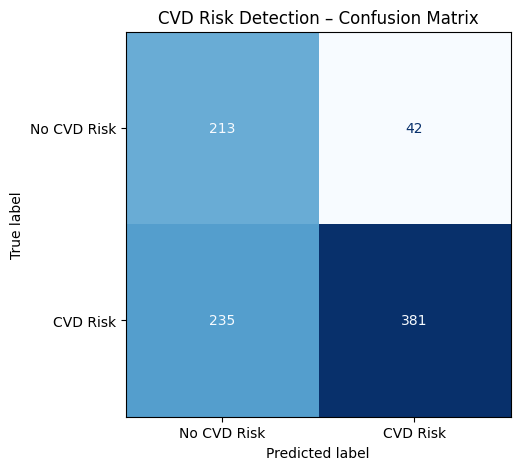


Classification Report:
              precision    recall  f1-score   support

         0.0      0.475     0.835     0.606       255
         1.0      0.901     0.619     0.733       616

    accuracy                          0.682       871
   macro avg      0.688     0.727     0.670       871
weighted avg      0.776     0.682     0.696       871



In [2]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# After the test evaluation block:
print("\nTEST RESULTS")
print(f"Loss {test_loss:.4f}  Acc {test_acc:.3f}  F1 {test_f1:.3f}  AUROC {test_auc:.3f}")

# Compute confusion matrix
cm = confusion_matrix(labels, preds)
print("\nConfusion Matrix (raw counts):")
print(cm)

# Optional: plot confusion matrix nicely
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No CVD Risk", "CVD Risk"])
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax, cmap="Blues", values_format="d", colorbar=False)
plt.title("CVD Risk Detection – Confusion Matrix")
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(labels, preds, digits=3))
